In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import math
from scipy import stats
from sklearn.decomposition import PCA
import ptitprince as pt

from IPython.display import HTML, display, Markdown

In [3]:
import popoff
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel
figure_path = '/home/jrowland/mnt/qnap/Figures/bois'

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [4]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## The region of cells to use and the covariates of interest are set here

In [24]:
region = 's1'
covs_keep = ['mean_pre', 'corr_pre', 'largest_PC_var', 'largest_singular_value', 'largest_factor_var',
             f'ts_{region}_pre', 'variance_cell_rates', 'variance_pop_mean',
            'mean_cell_variance']

## Init MultiSessionModel object with parameters

In [25]:
# Do you want to remove all cells that were ever targetted from all future analysis?
remove_targets = False
# Do you want to just analyse the three 'training set' sessions ([0,3,7]) indexes hardcoded
# as keep_sessions variable in PoolAcrossSessions
subsample_sessions = True
# Set hits with first lick < 250ms as toosoon?
remove_toosoon = True
# Build the MultiSessionModel object
msm = MultiSessionModel(remove_targets=remove_targets, subsample_sessions=subsample_sessions,
                         remove_toosoon = remove_toosoon)

lm = msm.linear_models[0]

In [8]:
string = msm.plot_string(region=region, is_plot=False)
print(string)

Hello Adam
Remove targets is False.
Remove too soon is True
Here are the sessions in play:
['Mouse J064, run 10', 'Mouse RL070, run 29', 'Mouse J065, run 10']
Cells in region s1 are included


In [9]:
def display_table(data):

    html = '<table style="table-layout:auto, width:180px">'

    for idx, row in enumerate(data):
        html += "<tr>"
        for idx2, field in enumerate(row):
            
            if idx == 0 or idx2 == 0:  # First column or row
                style = 'h3'
            else:
                style = 'br'
                
            html += f'<td style="width:100px"><{style}>{field}</{style}><td>'
            
        html += "</tr>"

    html += "</table>"

    display(HTML(html))

In [36]:
nd = 'No obvious difference'
cov_comment = {
    'mean_pre': 'Miss may be slightly higher but difference is not clear',
    'corr_pre': nd,
    'largest_PC_var': nd,
    'largest_singular_value': 'Miss clearly greater than hit',
    'largest_factor_var': nd,
    'ts_s1_pre': 'Hit greater than miss',
    'variance_cell_rates': 'Miss clearly greater than hit',
    'variance_pop_mean': nd,
    'mean_cell_variance': nd,
}

header = [f'Distribution across trials. N={len(msm.sessions)} Sessions',
          'Distribution across cells\n Single session']

data = []
data.append(['cell rates', 'N/A', 'The amplittude of both positive and '
             'negative going responses is greater'])
data.append(['pairwise correlations', 'N/A', nd])
data.append(['eigenspectrum', nd, 'N/A'])

# Population metrics
for cov in covs_keep:
    data.append([cov, cov_comment[cov], 'N/A'])

data.insert(0, [region.upper()] + header)

display_table(data)

In [12]:
def select_cells_and_frames(lm, region='s1', frames='pre'):
    
    flu = lm.flu
    flu = flu[lm.region_map[region], :, :]
    flu = flu[:, :, lm.frames_map['pre']]
    
    return flu

## Cell rates
### About plot
* A single session is shown. 
* Each bar is a cell
* Activity is meaned across time pre-stimulus and across trials
* The sort argument causes both hit and miss to be sorted separately

### Results
* There is a greater amplitude of both positive and negative responses on miss trials vs hit trials
* This result holds across all three sessions


In [40]:
def firing_rate_dist(lm, region, match_tnums=False, sort=False):
    
    flu = select_cells_and_frames(lm, region=region, frames='pre')

    flu = np.mean(flu, 2)  # Mean across time

    miss = flu[:, lm.session.outcome == 'miss']
    n_misses = miss.shape[1]

    hit = flu[:, lm.session.outcome == 'hit']
    n_hits = hit.shape[1]
    
    if match_tnums:
        keep_idx = np.random.choice(np.arange(n_hits), size=n_misses, replace=False)
        hit = hit[:, keep_idx]
        assert hit.shape[1] == miss.shape[1]
        
    # Mean across trials
    hit = np.mean(hit, 1)
    miss = np.mean(miss, 1)
    
    if sort:
        hit = np.sort(hit)
        miss = np.sort(miss)

    plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    bar_width = 2
    plt.bar(np.arange(len(hit)), hit, width=2, color=COLORS[0], label='hit')
    ylims = plt.gca().get_ylim()
    plt.legend()

    plt.subplot(2,1,2)
    plt.bar(np.arange(len(miss)), miss, width=2, color=COLORS[1], label='miss')
    plt.ylim(ylims)
    plt.xlabel('Cell ID')
    plt.legend()

    _ = plt.text(-50, (ylims[1]+ylims[0])/2, 'DF/F meaned across\nframes pre-stim and\nacross trials', 
             rotation=90, fontsize=20)

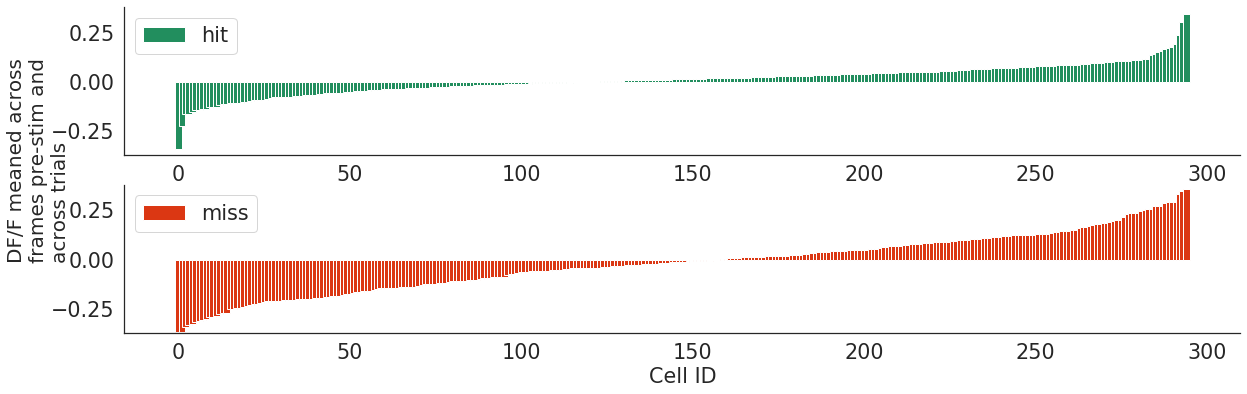

In [41]:
firing_rate_dist(lm, region=region, match_tnums=True, sort=True)

# Pairwise correlations

### About plot
* A single session is shown. 
* Each point is a pair of cells
* Pairwise pearson correlation is computed for each pair
* This is achieved by computing the cross-correlation matrix and taking the upper triangle of this matrix excluding the diagonal
* The sort argument causes both hit and miss to be sorted separately

### Results
* Very challenging to interpret due to the number of pairs, But there is no obvious difference between hit and miss

In [73]:
def pairwise_corr_plot(lm, sort=False):
    
    flu = select_cells_and_frames(lm, region=region, frames='pre')

    # Go through each trial
    correlations = []
    for trial in range(flu.shape[1]):
        data = flu[:, trial, :]  # [n_cells x time]
        corr_coef = np.corrcoef(data)
        # Indexs of the upper triangle of the corrcoef matrix
        # (not the diagonal)
        uptri_idxs = np.triu_indices(corr_coef.shape[0], k=1) 
        # Flattened vector of the upper triangle of corrcoef matrix
        correlations.append(corr_coef[uptri_idxs].ravel())

    correlations = np.array(correlations)
    hit = correlations[lm.session.outcome=='hit', :]
    miss = correlations[lm.session.outcome=='miss', :]

    # Mean across trials
    hit = np.mean(hit, 0)
    miss = np.mean(miss, 0)

    if sort:
        hit = np.sort(hit)
        miss = np.sort(miss)

    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.plot(np.arange(len(hit)), hit, '.', color=COLORS[0], label='hit')
    plt.legend(loc='upper right')
    ylims = plt.gca().get_ylim()

    plt.subplot(2,1,2)
    plt.plot(np.arange(len(miss)), miss, '.', color=COLORS[1], label='miss')
    plt.legend(loc='upper right')
    plt.ylim(ylims)

    plt.ylabel('Pairwise Pearson Correlation\n between all pairs of neurons', 
                 rotation=90, fontsize=20)
    plt.xlabel('Pair ID')

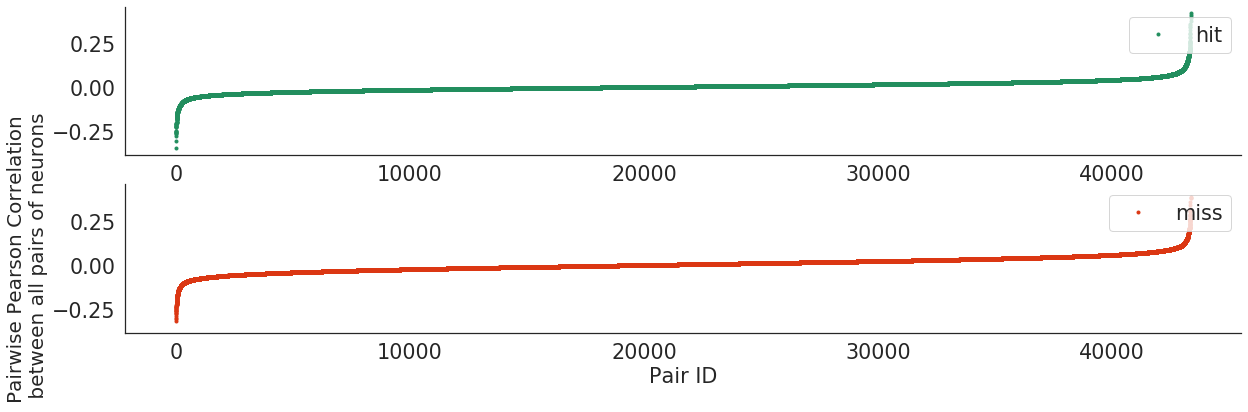

In [75]:
pairwise_corr_plot(lm, sort=True)


# Eigenspectrum

### About plot
* A single session is shown per subplot (three in total)
* The thick line is the mean eigenspectrum across all trials
* Each line is a trial
* The variance explained for the first N PCs is computed for an individual trial, frames pre-stim

### Results
* There is some hint that hit may be more low dimensional, but the result is not clear

In [45]:
def get_spectrum(X, n_components='all'):
    
    ''' Run PCA on data matrix

    Parameters
    -----------
    X : neural_activity matrix. [n_cells x time]
           (transposed before pca)
    n_components: number of principle components to compute
    '''

    if n_components == 'all':
        model = PCA()
    else:
        model = PCA(n_components=n_components)
    model.fit(X.T)
    varexp = model.explained_variance_ratio_
    svs = model.singular_values_
    
    return svs

In [50]:
def plot_spectrum(lm, region):
    flu = select_cells_and_frames(lm, region=region, frames='pre')

    # Go through each trial
    eigs = []
    for trial in range(flu.shape[1]):
        data = flu[:, trial, :]  # [n_cells x time]
        eigs.append(get_spectrum(data, 5))

    eigs = np.array(eigs)
    hit = eigs[lm.session.outcome=='hit', :]
    miss = eigs[lm.session.outcome=='miss', :]

    for trial in hit:
        plt.plot(trial, color=COLORS[0], alpha=0.1)
    plt.plot(np.mean(hit, 0), color=COLORS[0], label='hit', lw=4)

    for trial in miss:
        plt.plot(trial, color=COLORS[1], alpha=0.1)
    plt.plot(np.mean(miss, 0), color=COLORS[1], label='miss', lw=4)

    plt.legend()
    plt.xlabel('PC ID')
    plt.ylabel('Singular Value')

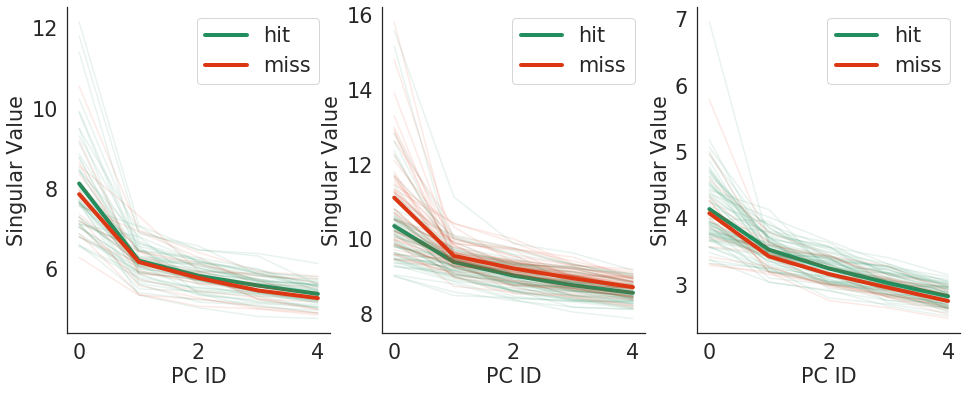

In [51]:
plt.figure(figsize=(16,6))
for idx, lm in enumerate(msm.linear_models):
    plt.subplot(1,3,idx+1)
    plot_spectrum(lm, region)

# Rainforest plots

### About plot
* All three sessions are shown
* Each point in a plot is a trial from a single sessions
* Every covariate is z-scored on a single session basis apart from the timescales

### Results
* variance_cell_rates and ts_sX_pre have hit vs miss differences

In [20]:
def get_covariates(lm, region, match_tnums=False):
    
    covariate_dict, y = lm.prepare_data('all', 'partial', n_comps_include=0,
                            outcomes=['hit', 'miss'],
                            region=region, return_matrix=False)
    
    covariate_dict['y'] = y
    
    if match_tnums:
        hit_idx = np.where(y==1)[0]
        miss_idx = np.where(y==0)[0]
        n_misses = len(miss_idx)
        hit_idx = np.random.choice(hit_idx, size=n_misses)
        keep_idx = np.hstack((hit_idx, miss_idx))
        covariate_dict = {k:v[keep_idx] for k,v in covariate_dict.items()}
        y = y[keep_idx]
    
        assert sum(y==0) == sum(y==1)
    
    return covariate_dict

In [21]:
no_norm = lambda x:x
norm_func_use = stats.zscore

cov_dicts = []
for linear_model in msm.linear_models:
    cov_dicts.append(get_covariates(linear_model, region))
    
dont_normalise = ['reward_history', 'n_cells_stimmed', 'y', 'trial_number', f'ts_{region}_pre']

data_dict = {}
# Iterate through each session and concatenate data into a single dict
for cov_dict in cov_dicts:
    for k, v in cov_dict.items():
        
        if k not in dont_normalise:
            # Select the norm function for covariates not in dont_normalise
            norm_func = norm_func_use
        else:
            norm_func = no_norm
            
        if k not in data_dict:
            data_dict[k] = norm_func(v)
        else:
            data_dict[k] = np.append(data_dict[k], (norm_func(v)))
            

/home/jrowland/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Text(0.5, 0.98, 'S1')

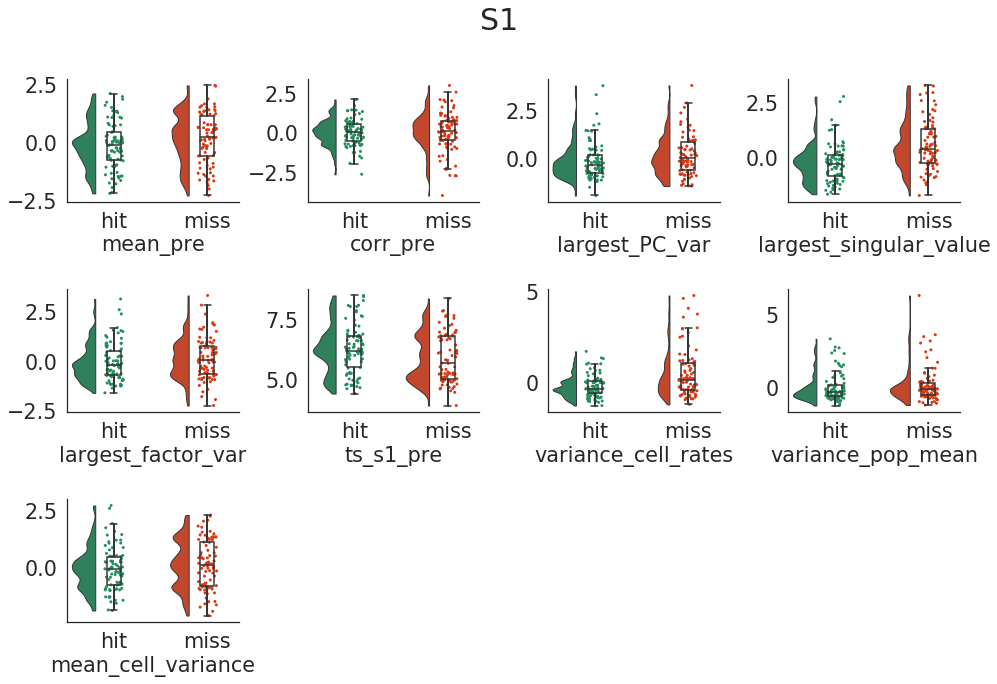

In [32]:
plt.figure(figsize=(16,10))
n_plots = 0

for cov_name in covs_keep:
    if cov_name in ['reward_history', 'n_cells_stimmed']:
        continue
    n_plots += 1
    ax = plt.subplot(3,4,n_plots)
    data = data_dict[cov_name]
    hit = data[data_dict['y'] == 1]
    miss = data[data_dict['y'] == 0]
    
    # Subsample hits to get the same number of both trials
    # wil break if more misses than hits
    idxs_keep = np.random.choice(np.arange(len(hit)), size=len(miss), replace=False)
    hit = hit[idxs_keep]
    assert len(hit) == len(miss)
    
    ax=pt.RainCloud(data = [hit, miss], palette = [COLORS[0], COLORS[1]], bw = .2,
                     width_viol = .5, ax = ax, orient = "v", showfliers=False, linecolor=[COLORS[0], COLORS[0]])
    plt.xlabel(cov_name)
    plt.xticks([0,1], ['hit', 'miss'])
plt.subplots_adjust(wspace=0.4, hspace=0.7)

plt.suptitle(region.upper(), fontsize=30)
